In [1]:
#https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history, title):
    print(history.history.keys())
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()

In [3]:
import os
def load_embeddings_index(glove_dir):
    embeddings_index = {}
    f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index
   
    

In [4]:
import pandas as pd
import numpy as np
import re;
Tweet = pd.read_csv('data/Tweets.csv', 'utf-8', delimiter=',')

Tweet['sentiment']=Tweet['airline_sentiment'].apply(lambda x: {'negative':0, 'neutral':1, 'positive':2}.get(x))
embeddings_index = load_embeddings_index('/common/workspaces/python-workspace/keras_virtual/venkat_sentiment_analysis/data/glove-global-vectors-for-word-representation')
print('Found %s word vectors.' % len(embeddings_index))
Tweet['cleaned_text'] = Tweet['text'].apply(lambda x: re.sub('[^a-zA-Z\s]','',x).lower())

Found 400000 word vectors.


In [5]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer 
from keras import preprocessing
from keras.utils import to_categorical

from keras.models import Sequential
from keras import layers


maxlen = 26
sentences = Tweet['cleaned_text'].values

tokenizer = Tokenizer(filters='')                                  
tokenizer.fit_on_texts(embeddings_index.keys())                                        

print(sentences[0])
sentences = tokenizer.texts_to_sequences(sentences) 
print(sentences[0])
sentences = preprocessing.sequence.pad_sequences(sentences, maxlen=maxlen, padding='post')

word_index = tokenizer.word_index                             

print('Found %s words in embeddings' % len(embeddings_index))
print('Found %s unique tokens.' % len(word_index))

emb_dim = embeddings_index['apple'].shape[0]
num_words = len(word_index) + 1

embedding_matrix = np.zeros((num_words, emb_dim))
for key in word_index:
    idx = word_index[key]
    vector = embeddings_index[key]
    embedding_matrix[idx, :] = vector

y = Tweet['sentiment'].values
y_encoded = to_categorical(y)

print(embedding_matrix.shape)

X_train, X_test, y_train, y_test = train_test_split(sentences,y_encoded, test_size=0.2,random_state=42)
input_dim = X_train.shape[1]  # Number of features
print('Number of input features %d.' % input_dim)


model = Sequential()
model.add(layers.Embedding(len(word_index) + 1, 100, input_length=maxlen))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(256, 5, padding='valid', activation='relu', strides=1))
model.add(layers.MaxPooling1D(pool_size=2, strides=1))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, 3, padding='valid', activation='relu', strides=1))
model.add(layers.MaxPooling1D(pool_size=2, strides=1))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.summary()

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])




history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=16)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))




Using TensorFlow backend.


virginamerica what dhepburn said
[103, 17]
Found 400000 words in embeddings
Found 400000 unique tokens.
(400001, 100)
Number of input features 26.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 100)           40000100  
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 256)           128256    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 21, 256)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 19,

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


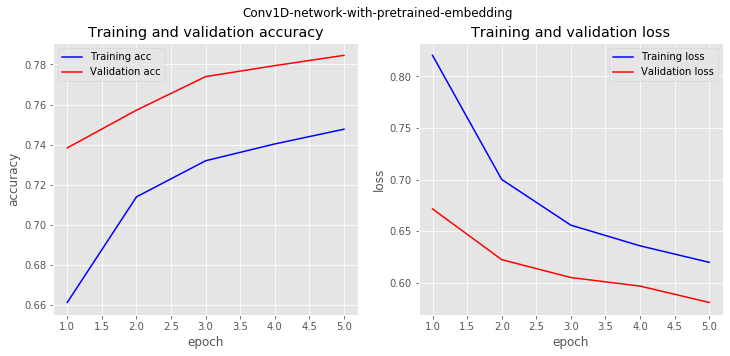

In [6]:
plot_history(history, 'Conv1D-network-with-pretrained-embedding')

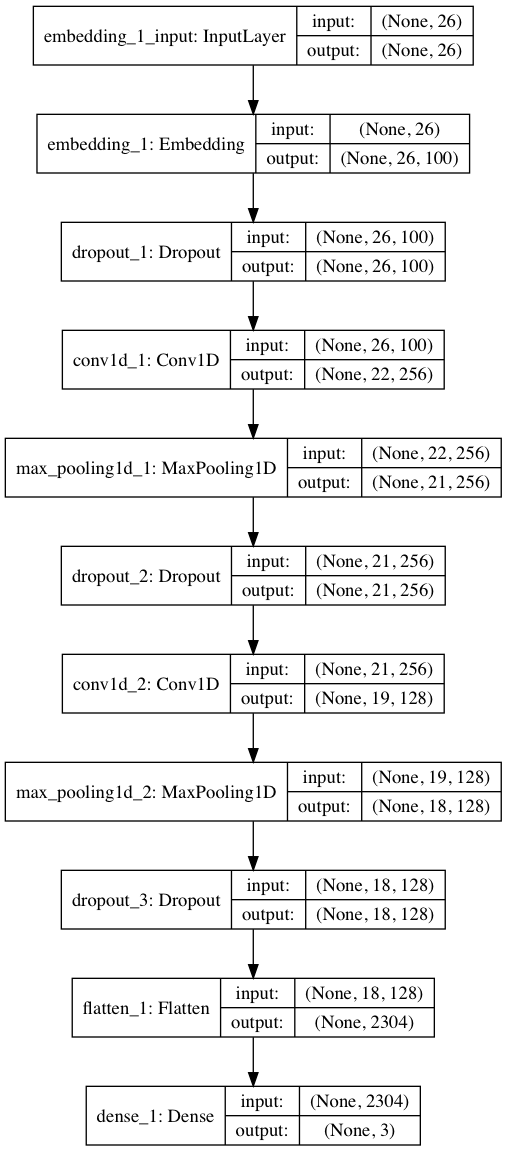

In [7]:
from keras.utils import plot_model
plot_model(model, to_file='Conv1D-network-with-pretrained-embedding.png', show_shapes=True, show_layer_names=True)

              precision    recall  f1-score   support

    negative       0.85      0.89      0.87      1889
     neutral       0.57      0.53      0.55       580
     postive       0.75      0.67      0.71       459

    accuracy                           0.78      2928
   macro avg       0.72      0.70      0.71      2928
weighted avg       0.78      0.78      0.78      2928



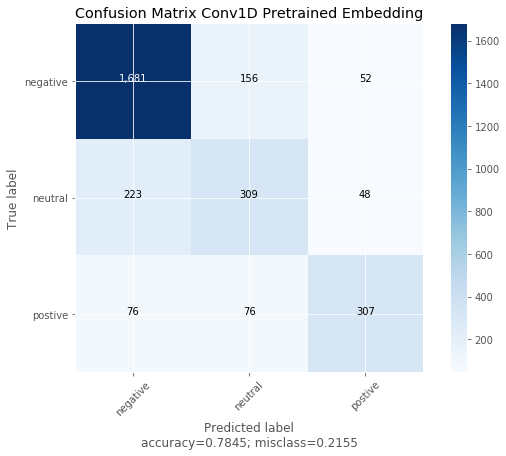

0.574638648022517

In [8]:
predictions =  model.predict(X_test)

predictions = np.argmax(predictions, axis=1)
y_test_true =  np.argmax(y_test, axis=1)


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 

target_names = ['negative', 'neutral', 'postive']
#target_names = ['negative', 'postive']
print(classification_report(y_test_true, predictions, target_names=target_names))
           
cm = confusion_matrix(y_test_true, predictions)
plot_confusion_matrix(cm, normalize=False, target_names = target_names,  title='Confusion Matrix Conv1D Pretrained Embedding')

from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test_true, predictions)